### Importing the Libraries

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import torchvision.transforms as T
from torchvision import models
from torchvision import datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#DEVICE = 'cpu'
DEVICE

device(type='cuda')

In [3]:
# Images are already in 48 X 48, so no need to resize
training_augs = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.Resize((48, 48)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize with mean=0.5 and std=0.5 (adjust for specific needs)
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=0, shear=0.2, scale=(0.8, 1.2))
])


training_set = datasets.ImageFolder(root='jonathan_oheix/train', transform=training_augs)

training_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
valid_augs = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_set = datasets.ImageFolder(root='jonathan_oheix/validation', transform=valid_augs)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
print(training_set.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [6]:
num_classes = len(training_set.classes)  # Number of emotion labels

# Load pretrained ResNet-50
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# Replace the last fully connected layer
#model.fc = nn.Linear(model.fc.in_features, num_classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Send the model to GPU if available
cnn = model.to(DEVICE)


In [7]:
print(cnn)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
summary(cnn, input_size=(3, 48, 48), device=DEVICE.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           1,792
              ReLU-2           [-1, 64, 48, 48]               0
            Conv2d-3           [-1, 64, 48, 48]          36,928
              ReLU-4           [-1, 64, 48, 48]               0
         MaxPool2d-5           [-1, 64, 24, 24]               0
            Conv2d-6          [-1, 128, 24, 24]          73,856
              ReLU-7          [-1, 128, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]         147,584
              ReLU-9          [-1, 128, 24, 24]               0
        MaxPool2d-10          [-1, 128, 12, 12]               0
           Conv2d-11          [-1, 256, 12, 12]         295,168
             ReLU-12          [-1, 256, 12, 12]               0
           Conv2d-13          [-1, 256, 12, 12]         590,080
             ReLU-14          [-1, 256,

In [9]:
LR = 0.1
EPOCHS = 50

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [11]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.cuda.FloatTensor))

In [12]:
def train_model(model, current_epoch, training_loader, optimizer, criterion, DEVICE):
    """
    Function to train the model for one epoch.
    """
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_acc = 0.0
    tk = tqdm(training_loader, desc="EPOCH" + "[TRAIN]" + str(current_epoch + 1) + "/" + str(EPOCHS))
    
    for t, data in enumerate(tk):
        # Transfer images and labels to the specified device
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Prepare the data for input
        #train = Variable(images.view(images.size(0), 1, 48, 48))
        train = images
        labels = Variable(labels)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(train)
        loss = criterion(outputs, labels)
        

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() # Total loss
        running_acc += multiclass_accuracy(outputs, labels)

        tk.set_postfix({'loss': '%6f' % float(running_loss / (t + 1)), 'acc': '%6f' % float(running_acc / (t + 1))})
    
    return running_loss / len(training_loader), running_acc / len(training_loader)

In [13]:
def test_model(model, current_epoch, test_loader, DEVICE):
    """
    Function to test the model and compute accuracy.
    """
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    predictions_list = []
    labels_list = []
    running_loss = 0.0
    running_acc = 0.0

    tk = tqdm(test_loader, desc="EPOCH" + "[VALID]" + str(current_epoch + 1) + "/" + str(EPOCHS))

    with torch.no_grad():  # Disable gradient calculation for testing
        for t, data in enumerate(tk):
            images, labels = data
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            labels_list.append(labels)

            #test = images.view(images.size(0), 1, 48, 48)
            test = images
            
            # Forward pass
            outputs = model(test)
            loss = criterion(outputs, labels)

            # Get predictions
            predictions = torch.max(outputs, 1)[1].to(DEVICE)
            predictions_list.append(predictions)
            correct += (predictions == labels).sum().item()
            total += len(labels)

            running_loss += loss.item()
            running_acc += multiclass_accuracy(outputs, labels)
            tk.set_postfix({'loss': '%6f' %float(running_loss / (t+1)), 'acc': '%6f' %float(running_acc / (t+1)), })

    #accuracy = 100 * correct / total
    return running_loss / len(test_loader), running_acc / len(test_loader), predictions_list, labels_list, 


In [14]:
# Reduce LR on Plateau
# Reduces the learning rate when a monitored metric (e.g., validation loss) stops improving.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)


In [15]:
# Main training loop

# Dictionary to store loss values over epochs
metrics_loss = {
    'training_loss': [],
    'validation_loss': []
}
# Dictionary to store accuracy values over epochs
metrics_accuracy = {
    'training_accuracy': [],
    'validation_accuracy': []
}

iteration_list = []
count = 0
best_valid_loss = np.inf
patience_counter = 0   # Tracks the number of epochs without improvement
early_stop = False # Flag to indicate whether to stop training
patience = 6

for current_epoch in range(EPOCHS):
    if early_stop:
        print("Early stopping triggered. Stopping training.")
        break
    print(f"Epoch {current_epoch + 1}, LR: {scheduler.optimizer.param_groups[0]['lr']}")
    print("")
    
    # Training step
    train_loss, train_accuracy = train_model(cnn, current_epoch, training_loader, optimizer, criterion, DEVICE)
    
    # Increment count for iterations
    count += len(training_loader)

    valid_loss, valid_accuracy, predictions_list, labels_list,  = test_model(cnn, current_epoch, test_loader, DEVICE)

    # Record metrics
    metrics_loss['training_loss'].append(train_loss)
    metrics_loss['validation_loss'].append(valid_loss)

    metrics_accuracy['training_accuracy'].append(train_accuracy)
    metrics_accuracy['validation_accuracy'].append(valid_accuracy)

    iteration_list.append(count)

    # Update the learning rate based on validation loss and print
    scheduler.step(valid_loss)
    

    if valid_loss < best_valid_loss:
        torch.save(cnn.state_dict(), 'best_weights_vgg_ADAM.pt')
        print("SAVED-BEST-WEIGHTS")
        best_valid_loss = valid_loss
        patience_counter = 0 # Reset early stopping
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")

    if patience_counter >= patience:
        print("Patience exceeded. Early stopping at epoch " +str(current_epoch + 1))
        early_stop = True


Epoch 1, LR: 0.1



EPOCH[VALID]1/50: 100%|██████████| 56/56 [00:56<00:00,  1.01s/it, loss=1.955518, acc=0.162185]


SAVED-BEST-WEIGHTS
Epoch 2, LR: 0.1



EPOCH[VALID]2/50: 100%|██████████| 56/56 [00:28<00:00,  1.95it/s, loss=1.812568, acc=0.256793]


SAVED-BEST-WEIGHTS
Epoch 3, LR: 0.1



EPOCH[VALID]3/50: 100%|██████████| 56/56 [00:26<00:00,  2.15it/s, loss=1.818781, acc=0.256246]


No improvement in validation loss for 1 epoch(s).
Epoch 4, LR: 0.1



EPOCH[VALID]4/50: 100%|██████████| 56/56 [00:23<00:00,  2.38it/s, loss=1.810146, acc=0.257888]


SAVED-BEST-WEIGHTS
Epoch 5, LR: 0.1



EPOCH[VALID]5/50: 100%|██████████| 56/56 [00:26<00:00,  2.12it/s, loss=1.810511, acc=0.258435]


No improvement in validation loss for 1 epoch(s).
Epoch 6, LR: 0.1



EPOCH[VALID]6/50: 100%|██████████| 56/56 [00:24<00:00,  2.32it/s, loss=1.813936, acc=0.257888]


No improvement in validation loss for 2 epoch(s).
Epoch 7, LR: 0.1



EPOCH[VALID]7/50: 100%|██████████| 56/56 [00:23<00:00,  2.42it/s, loss=1.816378, acc=0.256246]


No improvement in validation loss for 3 epoch(s).
Epoch 8, LR: 0.1



EPOCH[VALID]8/50: 100%|██████████| 56/56 [00:25<00:00,  2.23it/s, loss=1.812676, acc=0.255698]


No improvement in validation loss for 4 epoch(s).
Epoch 9, LR: 0.010000000000000002



EPOCH[VALID]9/50: 100%|██████████| 56/56 [00:25<00:00,  2.21it/s, loss=1.810231, acc=0.258982]


No improvement in validation loss for 5 epoch(s).
Epoch 10, LR: 0.010000000000000002



EPOCH[VALID]10/50: 100%|██████████| 56/56 [00:24<00:00,  2.32it/s, loss=1.809681, acc=0.257340]


SAVED-BEST-WEIGHTS
Epoch 11, LR: 0.010000000000000002



EPOCH[VALID]11/50: 100%|██████████| 56/56 [00:25<00:00,  2.22it/s, loss=1.808793, acc=0.256793]


SAVED-BEST-WEIGHTS
Epoch 12, LR: 0.010000000000000002



EPOCH[VALID]12/50: 100%|██████████| 56/56 [00:22<00:00,  2.49it/s, loss=1.810014, acc=0.257888]


No improvement in validation loss for 1 epoch(s).
Epoch 13, LR: 0.010000000000000002



EPOCH[VALID]13/50: 100%|██████████| 56/56 [00:20<00:00,  2.76it/s, loss=1.811791, acc=0.256793]


No improvement in validation loss for 2 epoch(s).
Epoch 14, LR: 0.010000000000000002



EPOCH[VALID]14/50: 100%|██████████| 56/56 [00:21<00:00,  2.59it/s, loss=1.809474, acc=0.257888]


No improvement in validation loss for 3 epoch(s).
Epoch 15, LR: 0.010000000000000002



EPOCH[VALID]15/50: 100%|██████████| 56/56 [00:14<00:00,  3.98it/s, loss=1.808968, acc=0.257888]


No improvement in validation loss for 4 epoch(s).
Epoch 16, LR: 0.0010000000000000002



EPOCH[VALID]16/50: 100%|██████████| 56/56 [00:27<00:00,  2.01it/s, loss=1.807524, acc=0.258982]


SAVED-BEST-WEIGHTS
Epoch 17, LR: 0.0010000000000000002



EPOCH[VALID]17/50: 100%|██████████| 56/56 [00:16<00:00,  3.46it/s, loss=1.808946, acc=0.258982]


No improvement in validation loss for 1 epoch(s).
Epoch 18, LR: 0.0010000000000000002



EPOCH[VALID]18/50: 100%|██████████| 56/56 [00:13<00:00,  4.08it/s, loss=1.808554, acc=0.259530]


No improvement in validation loss for 2 epoch(s).
Epoch 19, LR: 0.0010000000000000002



EPOCH[VALID]19/50: 100%|██████████| 56/56 [00:24<00:00,  2.26it/s, loss=1.808189, acc=0.257888]


No improvement in validation loss for 3 epoch(s).
Epoch 20, LR: 0.0010000000000000002



EPOCH[VALID]20/50: 100%|██████████| 56/56 [00:13<00:00,  4.09it/s, loss=1.808269, acc=0.257888]


No improvement in validation loss for 4 epoch(s).
Epoch 21, LR: 0.00010000000000000003



EPOCH[VALID]21/50: 100%|██████████| 56/56 [00:12<00:00,  4.38it/s, loss=1.808472, acc=0.258435]


No improvement in validation loss for 5 epoch(s).
Epoch 22, LR: 0.00010000000000000003



EPOCH[VALID]22/50: 100%|██████████| 56/56 [00:14<00:00,  3.78it/s, loss=1.808418, acc=0.258982]

No improvement in validation loss for 6 epoch(s).
Patience exceeded. Early stopping at epoch 22
Early stopping triggered. Stopping training.


In [16]:
import importlib
import visualization_plots

In [17]:
importlib.reload(visualization_plots)

<module 'visualization_plots' from 'c:\\Python_Codes\\cpe520\\visualization_plots.py'>

### SGD Optimizer

#### ROC Curve

#### Plot of Accuracy over epochs

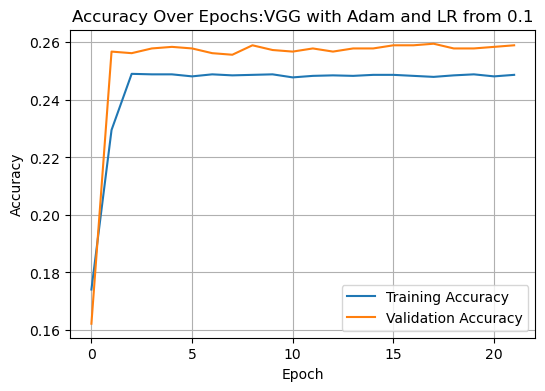

In [18]:
visualization_plots.plot_accuracy(metrics_accuracy, model_extra_desc="VGG with Adam and LR from 0.1")

#### Plot of Loss over epochs

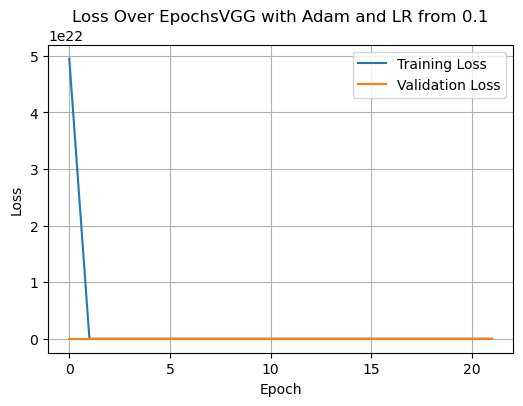

In [19]:
visualization_plots.plot_loss(metrics_loss, model_extra_desc="VGG with Adam and LR from 0.1")

#### Looking at the Accuracy in each class of dataset

In [20]:
label_classes = training_set.class_to_idx
# Switch keys and values
label_classes = {value: key for key, value in label_classes.items()}
label_classes

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [21]:
class_correct = [0. for _ in range(num_classes)]
total_correct = [0. for _ in range(num_classes)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        test = images
        outputs = cnn(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(num_classes):
    if total_correct[i] > 0:  # Avoid division by zero
        accuracy = class_correct[i] * 100 / total_correct[i]
        print(f"Accuracy of {label_classes[i]}: {accuracy:.3f}%")
    else:
        print(f"Accuracy of {label_classes[i]}: No samples")

Accuracy of angry: 0.000%
Accuracy of disgust: 0.000%
Accuracy of fear: 0.000%
Accuracy of happy: 100.000%
Accuracy of neutral: 0.000%
Accuracy of sad: 0.000%
Accuracy of surprise: 0.000%


#### Multipicture prediction plot